# Web Scraping and Data Analysis: Analyzing Jean's Under $50 on amazon Based on Sales Performance

## Background

This project was created as a learning exercise to practice web scraping and data analysis using publicly accessible Amazon search result pages. The main objective is to understand how HTML-based scraping works and how scraped data can be cleaned, validated, and analyzed for exploratory insights.

All actions performed in this project are intended for educational purposes only. No commercial use is intended. Any inaccuracies, inconsistencies, or misinterpretations in the data are unintentional and purely a result of learning and experimentation.

The dataset was collected by downloading HTML snapshots from Amazon search results for jeans priced under $50, specifically within the women’s jeans category. Only a limited number of pages were scraped, which may introduce bias and does not represent the full Amazon marketplace.

Writer: Muhammad Fauzy Harahap

Link: https://www.amazon.com/s?k=Jeans&rh=n%3A1040660%2Cn%3A1048188%2Cp_36%3A-5000&dc&ds=v1%3AZrh2YeJ%2Bmo6tc5p1QJD9idnCpBDTF2pKNTUbGqlhFKk&_encoding=UTF8&content-id=amzn1.sym.1cb3993a-41fc-4a2a-b2ee-016e70298d9f&crid=1TZCO6ZC2HZVA&pd_rd_r=a670fcb5-3cd3-446d-ba0f-093f4dc9e459&pd_rd_w=Xyfik&pd_rd_wg=5Ip8f&pf_rd_p=1cb3993a-41fc-4a2a-b2ee-016e70298d9f&pf_rd_r=QSC187FHC3P5S0VG0DAR&qid=1684823801&rnid=2941120011&sprefix=jeans%2Caps%2C155&ref=pd_hp_d_atf_unk

## Objectives



1. Analyze brand diversity within the Amazon jeans market to understand how fragmented or concentrated the competition is.

2. Examine gender distribution (women, men, and unisex) to identify dominant market segments.

3. Identify brands with the highest review counts as a proxy for popularity and market traction.

4. Evaluate brand power versus price, assessing whether well-known brands command higher prices.

5. Analyze the relationship between price and review count to understand how pricing relates to product popularity.

6. Measure brand value scores by combining ratings and review volume to estimate overall brand performance.

7. Assess brand saturation, identifying brands with many competing products within the same category.

8. Conduct rating inflation analysis to examine whether high ratings are widespread and less discriminative.

9. Evaluate style keyword effectiveness, analyzing which style attributes are associated with stronger performance.

10. Perform price segment analysis to compare product performance across different price ranges.

11. Analyze competitive density to identify highly crowded segments in the market.

12. Learn and apply web scraping techniques using saved HTML files as a practical approach to data collection when live scraping is restricted.

## Importing the dependency

In [35]:
import os
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import zipfile

# Web Scrapping

## Importing the data

In [ ]:
uploaded = files.upload()
ZIP_NAME = list(uploaded.keys())[0]
print("✅ Uploaded ZIP:", ZIP_NAME)

BASE_DIR = "/content/amazon_jeans_html"
os.makedirs(BASE_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_NAME, "r") as zip_ref:
    zip_ref.extractall(BASE_DIR)

print("✅ ZIP extracted to:", BASE_DIR)


files = []
for root, _, filenames in os.walk(BASE_DIR):
    for f in filenames:
        if f.lower().endswith((".htm", ".html")):
            files.append(os.path.join(root, f))

files = sorted(files)

print("📄 Total HTML files found:", len(files))
for f in files[:10]:
    print("-", os.path.basename(f))


In [ ]:
STYLE_KEYWORDS = [
    "high waisted", "mid rise", "low waisted", "wide leg", "baggy",
    "flare", "bootcut", "distress", "raw hem", "stretchy", "boyfriend"
]

def parse_review_count(text):
    if not text:
        return 0
    text = text.lower().replace(",", "").strip()
    match = re.search(r"[\d\.]+", text)
    if not match:
        return 0
    num = float(match.group())
    if "k" in text:
        num *= 1000
    return int(num)

def extract_brand(title):
    if not title:
        return "Unknown"
    return title.split()[0]

def extract_keywords(title):
    if not title:
        return []
    t = title.lower()
    return [kw for kw in STYLE_KEYWORDS if kw in t]


data = []

for file in files:
    print(f"📄 Parsing {file}")

    with open(os.path.join(BASE_DIR, file), "r", encoding="utf-8", errors="ignore") as f:
        soup = BeautifulSoup(f, "html.parser")

    products = soup.select("div[data-component-type='s-search-result']")

    for p in products:

        if p.select_one("span.s-sponsored-label-text"):
            continue

        title_tag = p.select_one("h2 span")
        title = title_tag.get_text(strip=True) if title_tag else None

        price = None
        price_tag = p.select_one("span.a-offscreen")
        if price_tag:
            try:
                price = float(
                    price_tag.text
                    .replace("IDR", "")
                    .replace("$", "")
                    .replace(",", "")
                    .strip()
                )
            except:
                price = None

        rating = None
        rating_tag = p.select_one("span.a-icon-alt")
        if rating_tag:
            try:
                rating = float(rating_tag.text.split()[0])
            except:
                rating = None

        review_tag = p.select_one("span.s-underline-text")
        review_count = parse_review_count(review_tag.text if review_tag else None)

        estimated_bought_last_month = review_count * 5

        data.append({
            "product_name": title,
            "brand": extract_brand(title),
            "style_keywords": extract_keywords(title),
            "price": price,
            "rating": rating,
            "review_count": review_count,
            "estimated_bought_last_month": estimated_bought_last_month
        })

df = pd.DataFrame(data)

df["rating"] = df["rating"].fillna(0)
df["price"] = df["price"].fillna(0)
df["review_count"] = df["review_count"].astype(int)
df["estimated_bought_last_month"] = df["estimated_bought_last_month"].astype(int)
df["brand"] = df["brand"].fillna("Unknown")
df["style_keywords"] = df["style_keywords"].apply(lambda x: x if isinstance(x, list) else [])

print(f"✅ Total products extracted: {len(df)}")
df.head(10)

# Data Preprocessing

##Data Cleaning

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   product_name                 300 non-null    object 
 1   brand                        300 non-null    object 
 2   style_keywords               300 non-null    object 
 3   price                        300 non-null    float64
 4   rating                       300 non-null    float64
 5   review_count                 300 non-null    int64  
 6   estimated_bought_last_month  300 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 16.5+ KB


In [37]:
df.isnull().sum()

,0
product_name,0
brand,0
style_keywords,0
price,0
rating,0
review_count,0
estimated_bought_last_month,0


In [38]:
df_temp = df.copy()
df_temp["style_keywords"] = df_temp["style_keywords"].apply(lambda x: ",".join(sorted(x)))
df_temp.duplicated().sum()

np.int64(36)

In [39]:
df.columns


Index(['product_name', 'brand', 'style_keywords', 'price', 'rating',
       'review_count', 'estimated_bought_last_month'],
      dtype='object')

In [40]:
df_clean = (
    df.sort_values("review_count", ascending=False)
      .drop_duplicates(subset=["product_name", "brand"], keep="first")
      .reset_index(drop=True)
)

print("After dedup:", len(df_clean))

After dedup: 254


Data was cleaned

## Data Validation

In [41]:
df.dtypes


,0
product_name,object
brand,object
style_keywords,object
price,float64
rating,float64
review_count,int64
estimated_bought_last_month,int64


In [42]:
df.isna().sum()


,0
product_name,0
brand,0
style_keywords,0
price,0
rating,0
review_count,0
estimated_bought_last_month,0


In [43]:
df_clean[(df_clean["rating"] < 0) | (df_clean["rating"] > 5)]

,product_name,brand,style_keywords,price,rating,review_count,estimated_bought_last_month


In [44]:
df_clean[df_clean["price"] <= 0]

,product_name,brand,style_keywords,price,rating,review_count,estimated_bought_last_month
12,Levi's Women's 311 Shaping Skinny Jeans (Stand...,Levi's,[],0.0,4.4,22500,112500
15,Levi Strauss Signature Gold Women's Totally Sh...,Levi,[bootcut],0.0,4.4,19600,98000
18,Levi Strauss Signature Gold Womens Modern Boot...,Levi,[bootcut],0.0,4.4,16200,81000
31,Levi's Women's Classic Straight Jeans,Levi's,[],0.0,4.2,6800,34000
40,Lee Womens Legendary Mid Rise Flare Jean,Lee,"[mid rise, flare]",0.0,4.2,4800,24000
72,Lee Womens Ultra Lux Comfort with Flex Motion ...,Lee,[],0.0,4.3,2100,10500


In [45]:
df_price = df_clean.dropna(subset=["price"])

In [46]:
df_clean[df_clean["price"].isna()].shape

(0, 7)

In [47]:
num_cols = [
    "price",
    "rating",
    "review_count",
    "estimated_bought_last_month"
]

df_num = df_clean[num_cols].copy()
df_num.dtypes

,0
price,float64
rating,float64
review_count,int64
estimated_bought_last_month,int64


In [48]:
df_num["price"] = df_num["price"].fillna(df_num["price"].median())
df_num["rating"] = df_num["rating"].fillna(0)
df_num["review_count"] = df_num["review_count"].fillna(0)
df_num["estimated_bought_last_month"] = df_num["estimated_bought_last_month"].fillna(0)

In [49]:
corr = df_num.corr()
corr

,price,rating,review_count,estimated_bought_last_month
price,1.000000,-0.011813,-0.233968,-0.233968
rating,-0.011813,1.000000,0.090029,0.090029
review_count,-0.233968,0.090029,1.000000,1.000000
estimated_bought_last_month,-0.233968,0.090029,1.000000,1.000000


In [50]:
df_eda = df_clean.drop(columns=["estimated_bought_last_month"])

In [51]:
df_eda["value_score"] = df_eda["rating"] * np.log1p(df_eda["review_count"])

Data validation ensures numerical consistency, removes invalid entries, explores correlations, and derives a value score as a proxy for market attractiveness

# Data Visualization & Analysist

## Brand Diversity

Total unique brands: 69


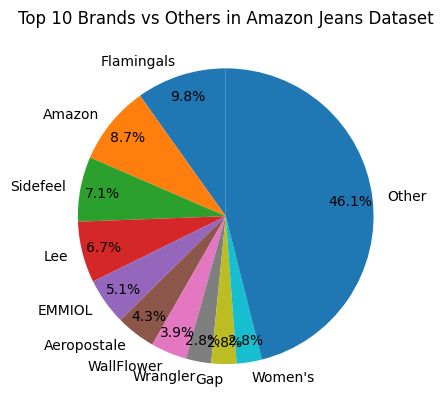

In [54]:
brand_counts = df_clean["brand"].value_counts()

top10 = brand_counts.head(10)

other = brand_counts.iloc[10:].sum()

brand_pie = pd.concat([top10, pd.Series({"Other": other})])

print("Total unique brands:", brand_counts.shape[0])

plt.figure()
brand_pie.plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.85
)
plt.title("Top 10 Brands vs Others in Amazon Jeans Dataset")
plt.ylabel("")
plt.show()

## Gender Distribution of Jeans Products

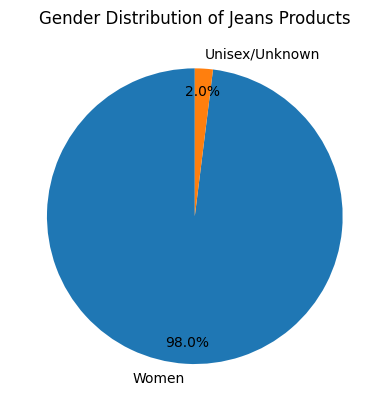

In [55]:
def infer_gender(title):
    if not isinstance(title, str):
        return "Unknown"

    t = title.lower()

    if "women" in t or "woman" in t or "womens" in t or "ladies" in t:
        return "Women"
    if "men" in t or "mens" in t or "man's" in t:
        return "Men"

    return "Unisex/Unknown"
df_clean["gender"] = df_clean["product_name"].apply(infer_gender)
df_clean["gender"].value_counts()
gender_counts = (
    df_clean["gender"]
    .replace({"Unknown": "Unisex/Unknown"})
    .value_counts()
)

plt.figure()
gender_counts.plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.85
)
plt.title("Gender Distribution of Jeans Products")
plt.ylabel("")
plt.show()

## Brands with highest review count

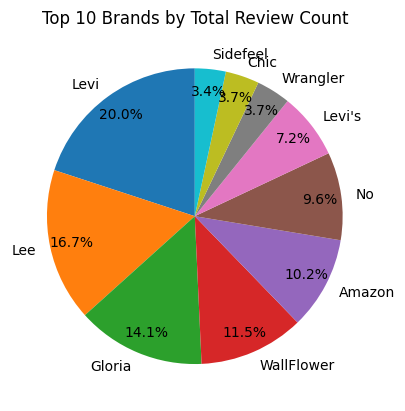

In [56]:
brand_reviews = (
    df_clean
    .groupby("brand")["review_count"]
    .sum()
    .sort_values(ascending=False)
)

top_brands = brand_reviews.head(10)

plt.figure()
top_brands.plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.85
)
plt.title("Top 10 Brands by Total Review Count")
plt.ylabel("")
plt.show()

## Brand Power vs Price

In [57]:
df_clean.groupby("brand").agg({
    "price": "median",
    "rating": "mean",
    "review_count": "sum"
}).sort_values("review_count", ascending=False).head(10)

,price,rating,review_count
brand,,,
Levi,301434.560,4.340000,154600
Lee,415789.100,4.276471,129484
Gloria,421473.380,4.380000,108914
WallFlower,452820.575,4.400000,89100
Amazon,300933.000,4.059091,78732
No,387200.460,4.250000,74400
Levi's,87270.570,4.300000,55800
Wrangler,587153.720,4.200000,28901
Chic,288226.940,4.200000,28600


## Style Keyword Performance

In [58]:
from collections import Counter

all_styles = Counter(
    kw for styles in df_clean["style_keywords"] for kw in styles
)

style_df = pd.DataFrame(all_styles.items(), columns=["style", "count"])
style_df.sort_values("count", ascending=False).head(10)

,style,count
5,wide leg,83
1,high waisted,74
2,stretchy,72
6,baggy,58
4,mid rise,36
7,flare,35
8,boyfriend,28
0,bootcut,25
3,distress,12
9,raw hem,11


## Price vs Review

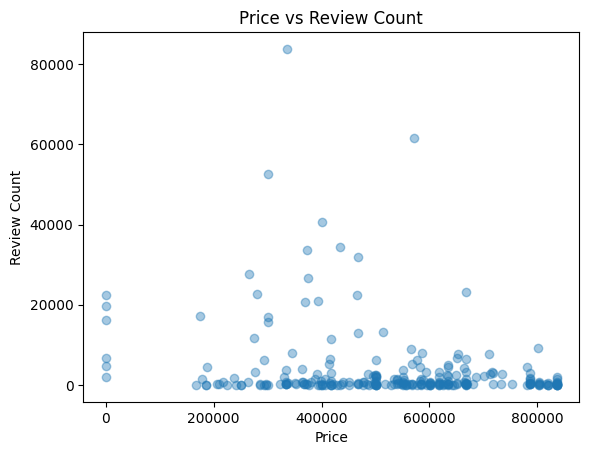

In [59]:
plt.figure()
plt.scatter(
    df_clean["price"],
    df_clean["review_count"],
    alpha=0.4
)
plt.xlabel("Price")
plt.ylabel("Review Count")
plt.title("Price vs Review Count")
plt.show()

## Brand Value Score Ranking

In [60]:
brand_value = (
    df_eda
    .groupby("brand")["value_score"]
    .mean()
    .sort_values(ascending=False)
)

brand_value.head(10)

,value_score
brand,
No,44.713211
Levi,44.465740
Signature,44.093786
Levi's,40.612279
Chic,40.109735
High,39.270795
Gloria,36.667151
Silver,36.450350
Democracy,35.240995


## Brand Saturation

In [61]:
brand_saturation = df_clean.groupby("brand").agg(
    total_products=("product_name", "count"),
    total_reviews=("review_count", "sum")
).sort_values("total_reviews", ascending=False)

brand_saturation.head(10)

,total_products,total_reviews
brand,,
Levi,5,154600
Lee,17,129484
Gloria,5,108914
WallFlower,10,89100
Amazon,22,78732
No,2,74400
Levi's,4,55800
Wrangler,7,28901
Chic,2,28600


## Rating Inflation Analysis

In [62]:
df_clean[
    (df_clean["rating"] >= 4.5) & (df_clean["review_count"] < 20)
].sort_values("rating", ascending=False).head(10)

,product_name,brand,style_keywords,price,rating,review_count,estimated_bought_last_month,gender
241,Amazon Essentials Women's Mid Rise Slim Straig...,Amazon,[mid rise],185408.16,4.7,18,90,Women


## Value for Money Ranking

In [63]:
df_eda.sort_values("value_score", ascending=False).head(10)

,product_name,brand,style_keywords,price,rating,review_count,value_score
0,Gloria Vanderbilt Women's Classic Tapered Aman...,Gloria,[],336877.78,4.3,83800,48.745661
1,WallFlower Luscious Curvy Bootcut Jeans for Wo...,WallFlower,[bootcut],571772.70,4.4,61600,48.525107
2,Levi Strauss Signature Gold Women's Totally Sh...,Levi,[],301434.56,4.2,52500,45.648067
3,No Nonsense Womens Stretch Denim Leggings with...,No,[],401244.00,4.3,40700,45.640234
6,Levi Strauss Signature Gold Women's Totally Sh...,Levi,[],467950.82,4.4,31800,45.615913
4,Levi Strauss Signature Gold Women's Mid-Rise S...,Levi,[],434681.00,4.3,34500,44.929597
12,Levi's Women's 311 Shaping Skinny Jeans (Stand...,Levi's,[],0.00,4.4,22500,44.093786
11,Signature by Levi Strauss & Co. Gold Womens Cu...,Signature,[],466278.96,4.4,22500,44.093786
5,"No nonsense Women’s Classic Denim Leggings, Je...",No,[high waisted],373156.92,4.2,33700,43.786188
13,Lee Women's Ultra Lux Comfort with Flex Motion...,Lee,[bootcut],392884.75,4.4,20900,43.769230


## Style Keyword Effectiveness

In [64]:
style_perf = []

for style in set(kw for s in df_clean["style_keywords"] for kw in s):
    subset = df_clean[df_clean["style_keywords"].apply(lambda x: style in x)]
    style_perf.append({
        "style": style,
        "avg_rating": subset["rating"].mean(),
        "avg_price": subset["price"].median(),
        "avg_reviews": subset["review_count"].mean()
    })

style_df = pd.DataFrame(style_perf).sort_values("avg_reviews", ascending=False)
style_df

,style,avg_rating,avg_price,avg_reviews
2,bootcut,4.216000,513090.760,6797.160000
1,distress,4.016667,635135.820,2236.333333
0,mid rise,4.233333,626776.570,1795.222222
4,high waisted,4.231081,583392.060,1449.081081
3,stretchy,4.243056,584980.320,1374.319444
6,flare,4.140000,551710.500,824.428571
10,raw hem,4.372727,581803.800,778.272727
7,boyfriend,4.092857,624018.015,753.892857
9,wide leg,4.236145,584980.320,716.903614
5,baggy,4.131034,618417.320,503.396552


## Price Segment Analysis

In [65]:
df_clean["price_segment"] = pd.qcut(
    df_clean["price"],
    q=3,
    labels=["Budget", "Mid-range", "Premium"]
)

df_clean.groupby("price_segment").agg(
    avg_rating=("rating", "mean"),
    avg_reviews=("review_count", "mean"),
    total_products=("product_name", "count")
)

/tmp/ipython-input-684668269.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby("price_segment").agg(


,avg_rating,avg_reviews,total_products
price_segment,,,
Budget,4.192941,6772.788235,85
Mid-range,4.225287,2687.356322,87
Premium,4.193902,1598.902439,82


## Competitive Density

In [66]:
df_clean.groupby("price_segment")["brand"].nunique()

/tmp/ipython-input-827769626.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby("price_segment")["brand"].nunique()


,brand
price_segment,
Budget,35
Mid-range,39
Premium,29


# Conclusion

The Amazon jeans market is highly competitive and fragmented, with women’s jeans dominating approximately 98% of all listings, confirming this segment as the primary area of demand and competition. Market performance is driven more by brand trust, review volume, and accessibility than by price or rating differences, as ratings are relatively inflated and consistent across brands and price segments. Budget and mid-range products generate significantly higher review volumes than premium items, indicating stronger sales activity at lower price points. Brands such as Levi, Lee, Amazon, Gloria Vanderbilt, and WallFlower demonstrate strong market positions through either scale-driven or efficiency-driven strategies, while popular styles including high-waisted, wide-leg, stretchy, and bootcut jeans reflect current consumer preferences toward comfort and modern silhouettes. Overall, success in this market depends on balancing competitive pricing, brand recognition, and trend relevance rather than relying on premium positioning alone.

## Note from the Writer

The analysis has several important limitations that should be considered when interpreting the results. Some brand names in the dataset may be invalid or inconsistent because certain product listings only include generic terms such as “Women” or “Amazon” rather than official brand identities, which can lead to misclassification. In addition, brand naming inconsistencies also exist, for example “Levi’s” and “Levi” are treated as separate brands in the dataset even though they represent the same brand, which may affect brand-level comparisons and aggregated insights. The dataset was collected from only the first five Amazon search result pages, meaning it does not fully represent the overall jeans marketplace and may introduce sampling bias toward more popular or highly ranked products. Furthermore, the “bought last month” variable is not an actual Amazon-provided metric but an estimated value derived by multiplying review counts by a fixed factor, which may significantly overestimate or underestimate real purchase activity. Consequently, the findings should be viewed as indicative trends for exploratory and educational purposes rather than precise or definitive market conclusions.